## Imports and setup

### Show initial state of environment

In [1]:
from highway_config import *
from dqn import *
import pprint

print(env.spec)
pprint.pprint(env.config)

c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EnvSpec(id='highway-fast-v0', entry_point='highway_env.envs:HighwayEnvFast', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='highway-fast', version=0, additional_wrappers=(), vector_entry_point=None)
{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,


c:\Users\adrie\anaconda3\envs\pytorch\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


Action space: Discrete(5)
Observation space: Box(-inf, inf, (5, 5), float32)


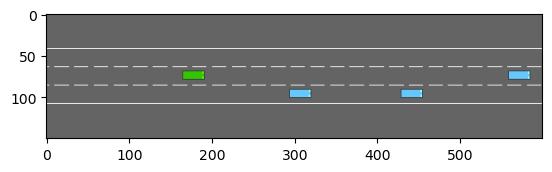

In [2]:
action_space = env.action_space
observation_space = env.observation_space

print(f"Action space: {action_space}")
print(f"Observation space: {observation_space}")

plt.imshow(env.render())
plt.show()

The observation space corresponds to the information available to the agent at each step. It then chooses an action based on this information. In our case (Kinematics observations), this info is a grid of vehicles_count * n_features where each value corresponds to a feature of a particular vehicule (not including the ego-vehicule ?). This space is stored in a Box object defined by (lower bound, upper bound, (vehicles_count, n_features), numerical_type). Since this observation space is in 2D, we had to flatten this matrix before feeding it into the DQN.

The action space is an integer that results from the available actions (longitudinal and/or lateral) and the quantization step (fixed by the parameter actions_per_axis). In the end there are actions_per_axis actions if only one of longiutdinal or lateral is True and actions_per_axis ** 2 if both are true.

## Utility functions

In [3]:
def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, 0)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')

## Training a DQN on highway-env

### Setup of the DQN agent and training loop

In [7]:
gamma = 0.8
batch_size = 32
buffer_capacity = 15_000
update_target_every = 32

epsilon_start = 0.8
decrease_epsilon_factor = 1000
epsilon_min = 0.02

hidden_size = 256

learning_rate = 5e-4

arguments = (env,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_min,
            learning_rate,
            hidden_size
        )

N_episodes = 300

print(arguments)

agent = DQN(*arguments)

def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done: 
            # print(f"State shape: {state.shape}")
            action = agent.get_action(state)
            # print(f"Action: {action}")

            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent, env)
            print("episode =", ep+1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break
                
    return losses

(<OrderEnforcing<PassiveEnvChecker<HighwayEnvFast<highway-fast-v0>>>>, 0.8, 32, 15000, 32, 0.8, 1000, 0.02, 0.0005, 256)


In [8]:
print(agent.q_net)

Net(
  (net): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)


### Run the training loop and evaluate agent

episode = 10 , reward =  7.157795576955843
episode = 20 , reward =  11.421200795214975
episode = 30 , reward =  17.223485062256934
episode = 40 , reward =  20.68876282785741
episode = 50 , reward =  22.000221166259717
episode = 60 , reward =  13.431883297809966
episode = 70 , reward =  22.539447809604468
episode = 80 , reward =  18.679838684032887
episode = 90 , reward =  18.266763136822725
episode = 100 , reward =  22.23997192558477
episode = 110 , reward =  20.900221169036342
episode = 120 , reward =  21.466826246287564
episode = 130 , reward =  20.420221169036335
episode = 140 , reward =  21.313038615151132
episode = 150 , reward =  13.9121327014218
episode = 160 , reward =  22.259847380809497
episode = 170 , reward =  20.92009662409847
episode = 180 , reward =  22.692532073133794
episode = 190 , reward =  22.03304763275121
episode = 200 , reward =  22.013305412493093
episode = 210 , reward =  18.442203497330297
episode = 220 , reward =  22.120221169036235
episode = 230 , reward =  

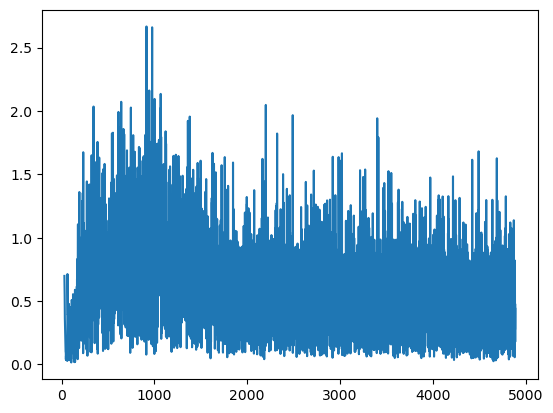

In [9]:
# Run the training loop
losses = train(env, agent, N_episodes)

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("rewards after training = ", rewards)
print("mean reward after training = ", np.mean(rewards))

### Show trained agent over one episode

KeyboardInterrupt: 

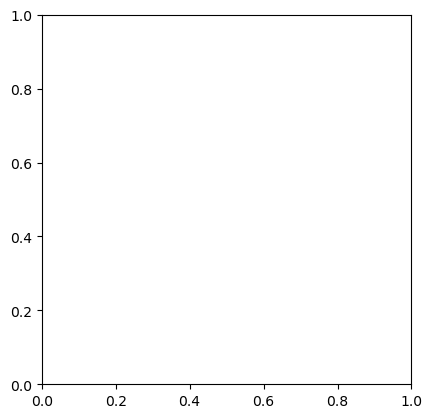

In [12]:
# os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

run_one_episode(env, agent, display=True)